In [3]:
!pip install cmake opencv-python
!conda install -y dlib
!pip install cmake

/bin/bash: line 1: conda: command not found


In [2]:
import cv2
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.12.0
19.24.6


1. 사람의 얼굴을 찾는다.
2. 랜드마크를 확인한다.
3. 스티커를 붙힐 위치를 파악한다.
4. 스티커를 스케일링한다.
5. 출력 오류를 제어한다.


In [5]:
!mkdir -p ~/work/camera_sticker/models
!mkdir -p ~/work/camera_sticker/images

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

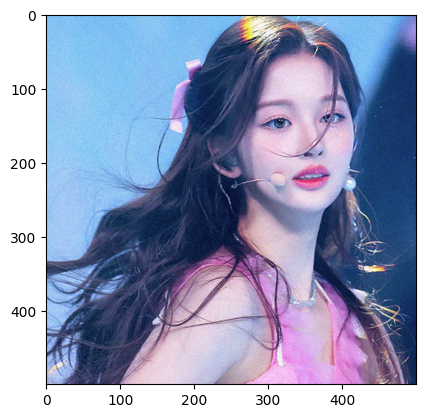

In [95]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/camera_sticker/images/image_1.jpg') # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path,1)

if img_bgr is None: #경로에 이미지가 존재하지 않는 경우 이를 알려주는 경고 메세지
    print(f"Error: Image not loaded. Check the path: {my_image_path}")
else:
    img_show = img_bgr.copy()
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

rectangles[[(270, 98) (425, 253)]]


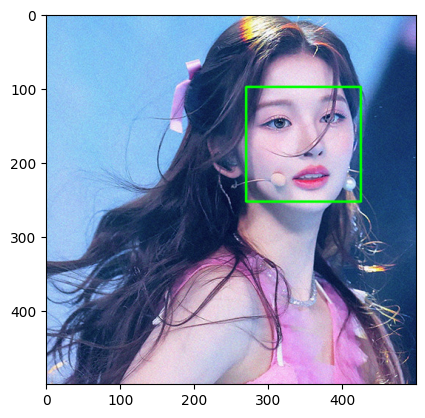

In [82]:
#detector, predictor setting
detector_hog = dlib.get_frontal_face_detector()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)

img_show = img_rgb.copy()

for dlib_rect in dlib_rects: #얼굴의 상하좌우를 l,t,r,b 변수에 저장
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    #이를 기반으로 얼굴을 표시하는 사각형을 그림

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show)
plt.show()

In [50]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 ~/work/camera_sticker/models
!cd ~/work/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

--2025-07-28 06:43:48--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-07-28 06:43:49--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  32.5MB/s    in 1.9s    

2025-07-28 06:43:51 (32.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file ./models/shape_predictor_68_face_landmarks.dat already exists.


In [51]:
model_path = os.path.join(home_dir, 'work/camera_sticker/models/shape_predictor_68_face_landmarks.dat')
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

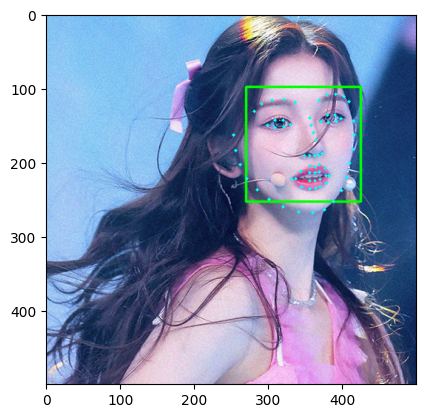

In [52]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)
plt.imshow(img_show)
    # 이미지를 준비
plt.show()


(364, 170)
(x,y) : (364,92)
(w,h) : (156,156)


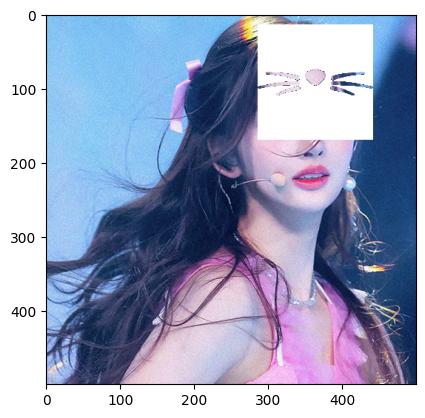

In [98]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')


sticker_path = os.path.join(home_dir, 'work/camera_sticker/images/cat-whiskers.png') # 왕관 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
refined_x = x - w //2
refined_y = y - h //2

if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
img = img_show.copy()


sticker_area = img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인


스티커를 붙히는건 성공했으나 위치와 투명도에 문제가 있어보임
png의 투명도를 담당하는 알파값을 변환해 반전을 일으키는 알파변환을 시도



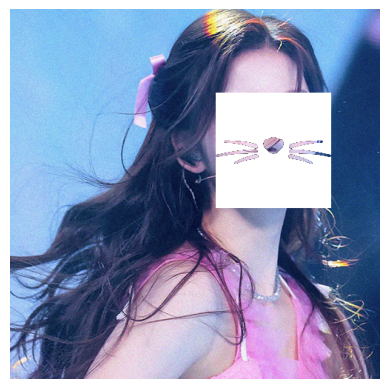

In [96]:
# (0) 스티커 불러오기 및 리사이즈
img_sticker = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
if img_sticker is None:
    raise FileNotFoundError("스티커 이미지가 없습니다!")
img_sticker = cv2.resize(img_sticker, (w, h))

# (1) 알파 채널 분리 + 반전
sticker_rgb = img_sticker[:, :, :3]
alpha = img_sticker[:, :, 3].astype(np.float32) / 255.0
alpha = 1.0 - alpha  # 반전!
alpha = alpha[:, :, np.newaxis]  # shape: (h, w, 1)

# (2) 위치 보정
refined_x = x - w // 2
refined_y = y
if refined_x < 0:
    sticker_rgb = sticker_rgb[:, -refined_x:]
    alpha = alpha[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    sticker_rgb = sticker_rgb[-refined_y:, :]
    alpha = alpha[-refined_y:, :]
    refined_y = 0

# (3) 알파 블렌딩
img = img_show.copy()
h_, w_ = sticker_rgb.shape[:2]
sticker_area = img[refined_y:refined_y+h_, refined_x:refined_x+w_]
blended = (alpha * sticker_rgb + (1 - alpha) * sticker_area).astype(np.uint8)

# (4) 이미지에 적용
img[refined_y:refined_y+h_, refined_x:refined_x+w_] = blended

# (5) 출력
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

알파전환을 이용해 스티커를 바꿔보려 했는데 이건 opencv자체적으로 다른것이기 때문에 문제가 있던것이다.

해서 이를 배경을 날리는 방식으로 바꿔서 시도해볼 예정


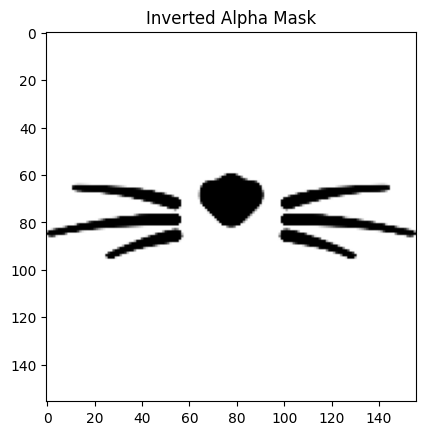

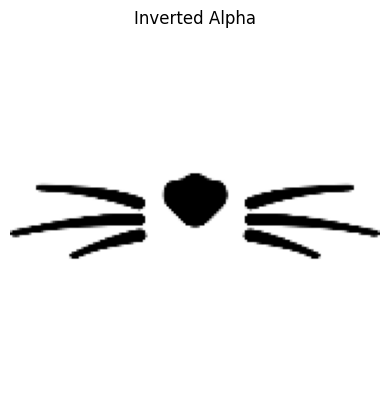

In [97]:
plt.imshow(alpha.squeeze(), cmap='gray')
plt.title('Inverted Alpha Mask')
plt.show()
plt.imshow(alpha.squeeze(), cmap='gray')
plt.title("Inverted Alpha")
plt.axis('off')
plt.show()

알파 시각화를 해보았지만 무엇이 문제인지 잘 모르겠다.

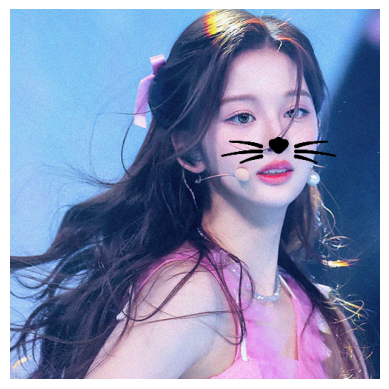

In [112]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    x = landmark[33][0] # 이미지에서 코 부위의 x값
    y = landmark[33][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)

# 스티커 이미지 불러오기 (PIL → RGBA 강제 변환)
sticker_path = os.path.join(home_dir, 'work/camera_sticker/images/cat-whiskers.png')
img_pil = Image.open(sticker_path).convert("RGBA")
img_sticker = np.array(img_pil)

# 리사이즈 (NumPy 배열 기준으로)
img_sticker = cv2.resize(img_sticker, (w, h))  # shape: (h, w, 4)

# RGB / 알파 분리
sticker_rgb = img_sticker[:, :, :3]
alpha = img_sticker[:, :, 3].astype(np.float32) / 255.0  # shape: (h, w)
alpha = alpha[:, :, np.newaxis]  # shape: (h, w, 1)

# 붙일 위치 계산
refined_x = x - w // 2
refined_y = y
if refined_x < 0:
    sticker_rgb = sticker_rgb[:, -refined_x:]
    alpha = alpha[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    sticker_rgb = sticker_rgb[-refined_y:, :]
    alpha = alpha[-refined_y:, :]
    refined_y = 0

# 원본 이미지 복사
img = img_show.copy()

# 스티커 붙일 영역 추출
h_, w_ = sticker_rgb.shape[:2]
sticker_area = img[refined_y:refined_y+h_, refined_x:refined_x+w_]

# 알파 블렌딩
blended = (alpha * sticker_rgb + (1 - alpha) * sticker_area).astype(np.uint8)
img[refined_y:refined_y+h_, refined_x:refined_x+w_] = blended

# 결과 출력
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

팔레트 기반 색상 이미지를 정상적인 RGBA로 변환하여 이를 접목시킴


In [114]:
def sticker_app(image_dir, image_num, target_size = None) :
  image_name = f"image_{image_num}.jpg"
  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
      raise FileNotFoundError(f"❌ 이미지 파일을 찾을 수 없습니다: {image_path}")

  img_pil = Image.open(image_path).convert("RGBA")
  img_np = np.array(img_pil)

  if target_size is not None:
      img_np = cv2.resize(img_np, target_size)

  sticker_rgb = img_np[:, :, :3]
  alpha = img_np[:, :, 3].astype(np.float32) / 255.0
  alpha = alpha[:, :, np.newaxis]

  return sticker_rgb, alpha

In [115]:
# 경로 설정
path ='work/camera_sticker/images/'
# 예: image_3.png 불러오기, 150x150으로 리사이즈
sticker_rgb, alpha = sticker_app(path, image_num=3, target_size=(150, 150))

# 이미지 확인
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(sticker_rgb, cv2.COLOR_BGR2RGB))
plt.title("Sticker RGB")
plt.axis('off')
plt.show()

FileNotFoundError: ❌ 이미지 파일을 찾을 수 없습니다: work/camera_sticker/images/image_3.jpg

얼굴각도
  얼굴 각도는 rotate함수를 이용해 해결할 수 있다.
  cv2.getRotationMatrix2D((회전지점좌표x,y), 각도, 이미지 크기)

  각도의 경우 얼굴의 수직선분중 가장 긴 landmark 8,27의 각도를 이용해 구할 수 있다.


이미지 밝기
  보통 RGB 중간값인 128을 사용하지만 너무 낮거나 너무 높은경우
  평균값이 128이 되도록 변경할 수 있다.
  cv2.add(img, val)
  cv2.substract(img, val)
  


촬영거리
  3d공간을 2d로 사영한 사진은 거리에 따라 크기가 작아진다.
  즉 얼굴의 크기를 upscaling을 통해 키우면 된다.
  cv2.resize(img, none, fx=scale, fy=scale)
  을 통해 이미지를 확대해 다시 시도해본다.

  또는
  DNN Super Resolution,
  Real-ESR/GAN
  과 같은 모듈 이용해 픽셀을 복원



